In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.notebook import tqdm

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Make the code reproducible
SEED = 42

# Load the data

In [3]:
df_all_declines_original = pd.read_csv('data/bb_from_declined_events.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'activity', 'views'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [4]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 4 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 4 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 4 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')])
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

# Add the channel's subs at the start of the decline
df_all_declines['Views_start'] = df_data_processed.loc[decline_index, 'views'].values

print(f"Overall recovery rate: {df_all_declines['Recovered'].mean():.5f}")

df_all_declines.head()

Overall recovery rate: 0.46430


,Channel,Duration,Mean_Number_of_Subscribers,Recovered,Start,End,Category,Subs_start,Activity_start,Views_start
0,UC1SqP7_RfOC9Jf9L_GRHANg,22,1.111359e+07,False,173,195,Music,1.174756e+07,0,5.055265e+09
1,UCLF-kfM8ZxHQ9lW_lpu_thw,19,2.932874e+06,False,190,209,Entertainment,3.209915e+06,23,4.307642e+09
2,UCLF-kfM8ZxHQ9lW_lpu_thw,16,2.932874e+06,False,228,244,Entertainment,3.396353e+06,23,4.616026e+09
3,UChGYKxkYdyi9e51dScmug6g,9,1.022885e+06,True,114,123,People & Blogs,1.008588e+06,2,2.802017e+07
4,UChGYKxkYdyi9e51dScmug6g,17,1.022885e+06,False,144,161,People & Blogs,1.063543e+06,1,3.419171e+07


In [5]:
df_all_declines.shape

(2955, 10)

In [6]:
df_all_declines.to_csv('data/bb_sampled_decline_events.csv', index=False)

# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we make the dataset balanced by using a matched observational study.

In [7]:
# Overall
counts = df_all_declines['Recovered'].value_counts(normalize=False)

counts

Recovered
False    1583
True     1372
Name: count, dtype: int64

In [10]:
# By category
counts = df_all_declines.groupby('Category')['Recovered'].value_counts(normalize=True).unstack().fillna(0) * 100

counts

Recovered,False,True
Category,,
Autos & Vehicles,10.000000,90.000000
Comedy,42.352941,57.647059
Education,59.493671,40.506329
Entertainment,51.527778,48.472222
Film and Animation,48.181818,51.818182
Gaming,45.333333,54.666667
Howto & Style,50.621118,49.378882
Music,83.148559,16.851441
News & Politics,52.380952,47.619048


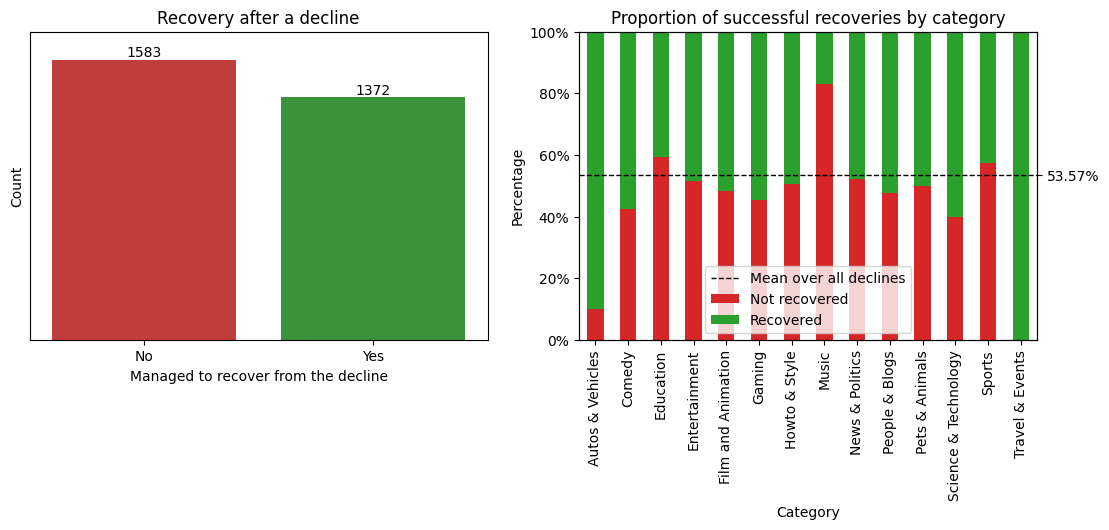

In [8]:
plot_recovered_by_categories(df_all_declines)